## Grad-Shafranov free-boundary problem

In [11]:
from firedrake import *
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [13]:
# Just to compile the solver functions without errors
mesh = UnitSquareMesh(3,3)
V = FunctionSpace(mesh, "P", 1)


### Fixed-point iterations solver:

In the cell below, functions that define the bilinear form in the variational formulation of Grad-Sahfranov are defined. In particular:
1. Defines the varf of nonlinear general GS 
2. Defines the varf of GS for a fixed point iteration

In [23]:
# Defines the bilinear form for the variational problem:
def GS_varf(G, phi, psi):
    # Define the bilinear form:
    a  = (dot(grad(psi), grad(phi)) + (1/x) * Dx(psi, 0) * phi) * dx - (G(x,psi) * phi) * dx
    # L = 0
    return a

# Define the variational formulation for the fixed point iteration:
def GS_varf_Picard(G, phi, psi, psi_old, psi_mask):
    # Define the bilinear form:
    a  = (dot(grad(psi), grad(phi)) + (1/x) * Dx(psi, 0) * phi) * dx - (psi_mask * G(x,psi_old) * phi) * dx
    # L = 0
    return a

In the cell below, a function that computes the plasma boundary with the computed $\psi$ and updates it for the following iteration.

In [ ]:
def update_plasma_boundary(psi, limiter_points, psi_mask):
    # Find the maximum value of psi at the limiter points:
    psi_vals = []
    for (x_pt, y_pt) in limiter_points:
        try:
            psi_vals.append(psi.at((x_pt, y_pt)))
        except:
            raise ValueError(f"Point {(x_pt, y_pt)} outside domain!")
    psi0 = max(psi_vals)

    # Update the plasma boundary mask:
    psi0_func = Function(V)
    psi0_func.interpolate(Constant(psi0))
    #psi_mask_new = Function(V)
    #psi_mask_new.interpolate(conditional(psi < psi0_func, 1.0, 0.0))
    
    # Compute error between old and new mask:
    #boundary_error = norm(psi_mask_new - psi_mask, 'L2')

    # Update the mask:
    #psi_mask.assign(psi_mask_new)
    #return psi0, boundary_error

    psi_mask.interpolate(conditional(psi < psi0_func, 1.0, 0.0))
    return psi0

In the cell below, function "GradShafranov" solves the free-boundary Grad-Shafranov problem by using fixed point method.

In [78]:
def GradShafranov(G, limiter_points, initial_guess = None):

  # Define trial and test functions:
  psi = Function(V)
  phi = TestFunction(V)

  # Initialize the plasma boundary as the whole domain:
  psi_mask = Function(V, name="Flux Mask")
  psi_mask.interpolate(Constant(1.0)) # Solve over the whole domain at first iteration

  # Initialize the flux function:
  psi_old = Function(V, name="Flux Old")
  if initial_guess is not None:
    psi_old.interpolate(initial_guess(x,y))
  else:
    psi_old.interpolate(Constant(0.0))

  # Define homogeneous Dirichlet boundary condition:
  bc = DirichletBC(V, 0.0, 'on_boundary')

  # Solve with Picard iterative method:
  maxit = 100
  it = 0
  tol = 1e-3
  #tol_bdry = 1e-3
  err = tol+1

  while it < maxit and err > tol: #and boundary_error > tol_bdry:
    # Define the variational problem:
    a = GS_varf_Picard(G, phi, psi, psi_old, psi_mask)
    solve(a == 0, psi, bcs=[bc])

    # Compute the error:
    err = errornorm(psi, psi_old, 'H1') / norm(psi_old, 'H1')

    # Update the mask for plasma boundary:
    #psi0, boundary_error = update_plasma_boundary(psi, limiter_points, psi_mask)
    psi0 = update_plasma_boundary(psi, limiter_points, psi_mask)

    # Print the iteration values:
    #print("Iteration = ", it, " Error = ", err, " $\Omega_p$ at $\psi= ", psi0, " Boundary Error = ", boundary_error)
    print("Iteration = ", it, " Error = ", err, " psi at boundary = ", psi0)

    # Update the old flux function:
    psi_old.assign(psi)

    # Check number of iterations:
    it += 1
    if it > maxit: 
      print('Nonlinear solver di NOT converge!\nRelative error =', err, 'after', it, 'iterations.')

  return psi, psi0

### Solov'ev equilibrium - a simple example

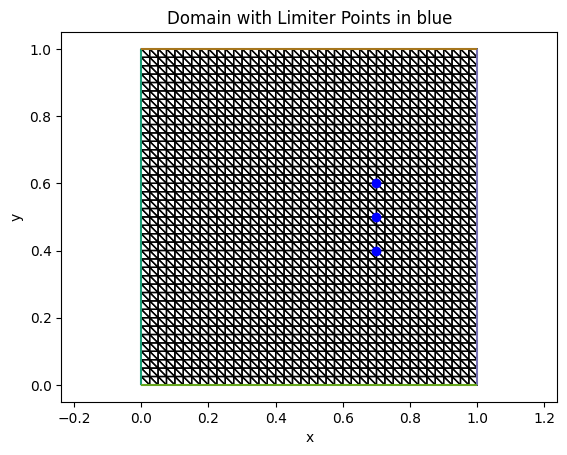

In [80]:
n = 40
mesh = UnitSquareMesh(n,n)
V = FunctionSpace(mesh, "P", 2)
x, y = SpatialCoordinate(mesh)

# Define the limiter points:
limiter_points = [(0.7,0.4), (0.7,0.5), (0.7,0.6)]

# Display mesh:
fig, ax = plt.subplots()
triplot(mesh, axes=ax)
plt.scatter(*zip(*limiter_points), color='blue', label='Limiter Points')
plt.title(r"Domain with Limiter Points in blue")
plt.xlabel("x")
plt.ylabel("y")
plt.axis('equal')
plt.show()

In [85]:
# Define G function:
def G(x, psi):
    return x**2 + 1.0

# Define initial guess for the flux function:
def initial_guess(x, y):
    return 0.5 * x * (1 - x) * y * (1 - y)

# Compute solution using Grad-Shafranov solver:
psi, psi0 = GradShafranov(G, limiter_points, initial_guess)

Iteration =  0  Error =  1.9984859205899428  psi at boundary =  0.08326690704710975
Iteration =  1  Error =  0.05342466294994966  psi at boundary =  0.07692636669945044
Iteration =  2  Error =  0.03598925685983681  psi at boundary =  0.07344415344206501
Iteration =  3  Error =  0.08920197686590717  psi at boundary =  0.08288370619239843
Iteration =  4  Error =  0.05612364599429179  psi at boundary =  0.07639181132880202
Iteration =  5  Error =  0.04300783346469104  psi at boundary =  0.07207590366809265
Iteration =  6  Error =  0.09970732107990751  psi at boundary =  0.08275023975270868
Iteration =  7  Error =  0.055642441800804805  psi at boundary =  0.07630000686443703
Iteration =  8  Error =  0.04243341909249924  psi at boundary =  0.07220843239982258
Iteration =  9  Error =  0.0959872280276807  psi at boundary =  0.08204683965539704
Iteration =  10  Error =  0.06159810022151775  psi at boundary =  0.07526772960717427
Iteration =  11  Error =  0.0331064578088721  psi at boundary =  

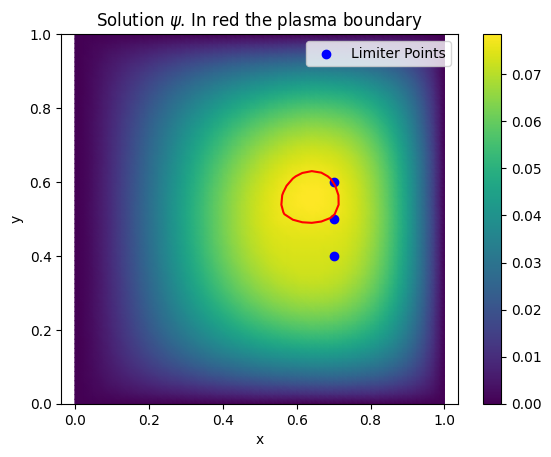

In [86]:
# Plot the solution:
X, Y = np.meshgrid(np.linspace(0, 1, n), np.linspace(0, 1, n))
PSI = np.zeros_like(X)
for i in range(n):
    for j in range(n):
        point = (X[j, i], Y[j, i])  # Note: meshgrid ordering
        try:
            PSI[j, i] = psi.at(point)  # psi.at expects a tuple (x,y)
        except:
            PSI[j, i] = np.nan         # Mark outside points as nan

fig, ax = plt.subplots()
fig.colorbar(tripcolor(psi, axes=ax))
plt.contour(X, Y, PSI, levels=[psi0], colors='red')
plt.scatter(*zip(*limiter_points), color='blue', label='Limiter Points')
plt.title(r"Solution $\psi$. In red the plasma boundary")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.axis('equal')
plt.show()